Name: Vijaykumar Maraviya

Student Number: 1006040320

In [1]:
import gym
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
from sklearn.preprocessing import KBinsDiscretizer
from itertools import product
import collections

### Mountain Car environment and discretization of state space

In [22]:
mc_env = gym.make('MountainCar-v0')
mc_env.reset()

# lower bounds of state space
lower_bounds = mc_env.observation_space.low

# upper bounds of state space
upper_bounds = mc_env.observation_space.high

n_bins = (40, 40)

# discretize the state
def mc_discretizer(car_position, car_velocity):
    est = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='uniform')
    est.fit([lower_bounds, upper_bounds ])
    return tuple(map(int, est.transform([[car_position, car_velocity]])[0]))

# action_space
mc_action_space = [0,1,2]

# discretized state_space
mc_state_space = []
for s in product(range(40), range(40)):
    mc_state_space.append(s)

### performance test

In [20]:
def test(Q, eps, num_episodes = 1000):
    rewards = np.zeros(num_episodes)
    for i in range(num_episodes):
        totalReward = 0
        observation = mc_discretizer(*mc_env.reset())
        done = False
        while not done:
            action =  e_greedy(Q, eps, observation, mc_action_space)
            observation_, reward, done, info = mc_env.step(action)            
            observation = mc_discretizer(*observation_)
            totalReward += reward
        rewards[i] = totalReward
    
    print(f"Average reward over {num_episodes} episodes: {np.average(rewards):.2f}")
    print(f"number of successes (reward >= -199) in {num_episodes} episodes: {np.sum(np.where(rewards >= -199, 1, 0))}")
    
    plt.plot(rewards)
    plt.xlabel('episode number')
    plt.ylabel('reward')
    plt.show()

## Implementation

This function selects an action using e-greedy policy for a given Q

In [4]:
def e_greedy(Q, eps, S, action_space):
    # random action with probability eps
    if np.random.random() < eps:
        return np.random.choice(action_space)
    
    # greedy action otherwise
    act_vals = np.array([Q[(S,a)] for a in action_space])
    return np.random.choice(np.where(act_vals == act_vals.max())[0])

In [5]:
def decay_eps(current_eps, eps_min, eps_dec):
    new_eps = current_eps - eps_dec
    return max(new_eps, eps_min)

### a. on-policy SARSA

In [6]:
def on_policy_SARSA(env, state_space, action_space, descritizer,
                    max_episodes = 50000, GAMMA = 1.0,
                    EPS_MAX = 1.0, EPS_MIN = 0.0, eps_dec = None,
                    ALPHA = 0.1):
    
    if eps_dec is not None:
        eps_dec = eps_dec
    else:
        eps_dec = (EPS_MAX - EPS_MIN)*2/max_episodes
        
    eps = EPS_MAX
        
    # intialize Q
    Q = {}
    for s in state_space:
        for a in action_space:
            Q[(s,a)] = 0
            
#     max_position = -0.4
    
    reward_list = []
    
    # loop for max_episodes
    for n_eps in range(max_episodes):
        # initialize S
        obs = env.reset()
        S = descritizer(*obs)
        
        # choose A
        A = e_greedy(Q, eps, S, action_space)
        
        total_reward = 0
        done = False
        while not done:            
            # take action A, observe R and S_next
            obs, R, done, _ = env.step(A)
            S_next = descritizer(*obs)
            
            total_reward += R
            
            # choose A_next
            A_next = e_greedy(Q, eps, S_next, action_space)
            
#             if obs[0] > max_position:
#                 max_position = obs[0]
#                 R += 10
            
            # updtae Q
            Q[(S,A)] = Q[(S,A)] + ALPHA*(R + GAMMA*Q[(S_next, A_next)] - Q[(S,A)])
            
            # next S, A
            S, A = S_next, A_next
        
        eps = decay_eps(eps, EPS_MIN, eps_dec)
        
        reward_list.append(total_reward)
        
    return Q, reward_list

In [ ]:
np.random.seed(1)
# on-policy SARSA
_Q_on_policy_sarsa, _reward_list = on_policy_SARSA(env = mc_env,
                                    state_space = mc_state_space,
                                    action_space = mc_action_space,
                                    descritizer = mc_discretizer, 
                                    max_episodes = 10000, 
                                    GAMMA = 1.0, 
                                    EPS = 0.1,
                                    ALPHA = 0.01)

In [ ]:
plt.figure(2, figsize=[10,5])
_rewards = pd.Series(_reward_list)
rm_r = _rewards.rolling(100).mean()
plt.plot(_rewards, alpha=0.8)
plt.plot(rm_r)
plt.xlabel('Episode')
plt.ylabel('reward')
plt.title('rewards vs episodes')
# plt.savefig('Final Position.png')
plt.show()

In [7]:
np.random.seed(1)
# on-policy SARSA
Q_on_policy_sarsa, reward_list = on_policy_SARSA(env = mc_env,
                                    state_space = mc_state_space,
                                    action_space = mc_action_space,
                                    descritizer = mc_discretizer, 
                                    max_episodes = 10000, 
                                    ALPHA = 0.1)

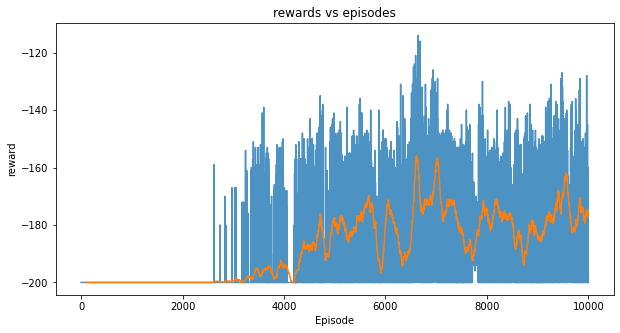

In [8]:
plt.figure(2, figsize=[10,5])
rewards = pd.Series(reward_list)
rm_r = rewards.rolling(100).mean()
plt.plot(rewards, alpha=0.8)
plt.plot(rm_r)
plt.xlabel('Episode')
plt.ylabel('reward')
plt.title('rewards vs episodes')
plt.show()

In [18]:
mc_env = gym.make('MountainCar-v0')
observation = mc_discretizer(*mc_env.reset())
done = False
while not done:
    action =  e_greedy(Q_on_policy_sarsa, 0, observation, mc_action_space)
    observation_, reward, done, info = mc_env.step(action)            
    observation = mc_discretizer(*observation_)
    mc_env.render()
mc_env.close()

Average reward over 100 episodes: -181.75
number of successes (reward >= -199) in 100 episodes: 56


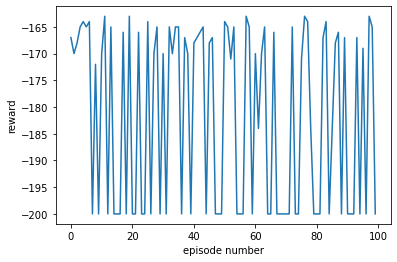

In [21]:
# target policy is e-greedy (same as behaviour policy)
test(Q_on_policy_sarsa, 0, 100)

### b. off-policy Q learning

In [28]:
def off_policy_Q(env, state_space, action_space, descritizer, 
                 max_episodes = 10000, GAMMA = 1.0,
                 EPS = 0.1,
                 ALPHA_MAX = 1.0, ALPHA_MIN = 0.005 ):
    
    # for reproducible results
    env.seed(0)
    np.random.seed(0)
    
    # intialize Q
    Q = {}
    for s in state_space:
        for a in action_space:
            Q[(s,a)] = 0
    
    eps = 0.1
    
    reward_list = []
            
    # loop for max_episodes
    for n_eps in range(max_episodes):
        
        alpha = max(ALPHA_MIN, ALPHA_MAX * (0.85 ** (n_eps//100)))
        
        # initialize S
        obs = env.reset()
        S = descritizer(*obs)
        
        total_reward = 0
        done = False
        while not done: 
            # choose A (behaviour policy e-greedy)
            A = e_greedy(Q, eps, S, action_space)
            
            # take action A, observe R and S_next
            obs, R, done, _ = env.step(A)
            S_next = descritizer(*obs)
            
            total_reward += R
            
            # target policy is greedy w.r.t to Q
            Q_max = max([ Q[(S_next, a)] for a in action_space])
            
            # updtae Q
            Q[(S,A)] = Q[(S,A)] + alpha*(R + GAMMA*Q_max - Q[(S,A)])
            
            # next S, A
            S = S_next
            
        reward_list.append(total_reward)
        
    return Q, reward_list

In [32]:
# off-policy Q learning
Q_off_policy_Q, reward_list = off_policy_Q(env = mc_env,
                              state_space = mc_state_space,
                              action_space = mc_action_space,
                              descritizer = mc_discretizer, 
                              max_episodes = 50000, 
                              GAMMA = 1.0)

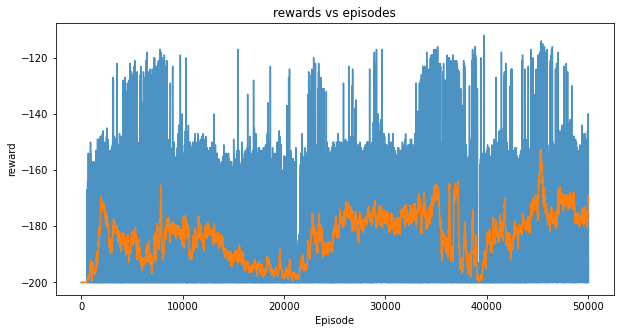

In [38]:
plt.figure(2, figsize=[10,5])
rewards = pd.Series(reward_list)
rm_r = rewards.rolling(100).mean()
plt.plot(rewards, alpha=0.8)
plt.plot(rm_r)
plt.xlabel('Episode')
plt.ylabel('reward')
plt.title('rewards vs episodes')
plt.show()

Average reward over 100 episodes: -160.03
number of successes (reward >= -199) in 100 episodes: 94


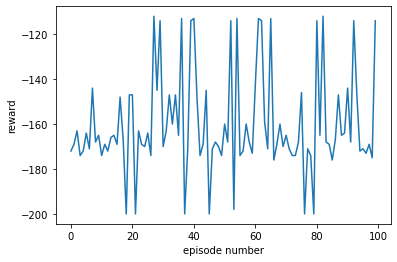

In [34]:
# target policy is greedy w.r.t to Q (hence epsilon = 0)
test(Q_off_policy_Q, 0, 100)

### c. off-policy Expected SARSA

In [ ]:
def Expected_SARSA(env, state_space, action_space, descritizer, max_episodes = 100000, GAMMA = 1.0, EPS = 0.1, ALPHA = 0.5):
    eps = EPS
    # intialize Q
    Q = {}
    for s in state_space:
        for a in action_space:
            Q[(s,a)] = 0
            
    # loop for max_episodes
    for n_eps in range(max_episodes):
        # initialize S
        obs = env.reset()
        S = descritizer(*obs)
        
        done = False
        while not done: 
            # choose A (behaviour policy e-greedy)
            A = e_greedy(Q, eps, S)
            
            # take action A, observe R and S_next
            obs, R, done, _ = env.step(A)
            S_next = descritizer(*obs)
            
            # expected value
            Q_expected = np.mean(np.array([ Q[(S_next, a)] for a in action_space]))
            
            # updtae Q
            Q[(S,A)] = Q[(S,A)] + ALPHA*(R + GAMMA*Q_expected - Q[(S,A)])
            
            # next S, A
            S = S_next
        
    return Q

### c.2 off-policy expected SARSA with an epsilon greedy policy as a target policy

The assignment asked to implement off-policy Expected SARSA with an epsilon-greedy policy. It wasn't clear whether the e-greedy policy is to be used only for behaviour or also for target. So, I have also implemented off-policy Expected SARSA with greedy policy as a target policy. The values of epsilon for behaviour and target policy are different. If they are same, then the algorithm becomes on-policy Expected SARSA.

In [ ]:
def calculate_expected_Q(Q, S, eps):
    if Q[(S,0)] >= Q[(S,1)]:
        expected_value = (1-eps + eps/2)*Q[(S,0)] + (eps/2)*Q[(S,1)]
    else:
        expected_value = (1-eps + eps/2)*Q[(S,1)] + (eps/2)*Q[(S,0)]
    
    return expected_value

def Expected_SARSA_e_greedy(env, state_space, action_space, descritizer,
                            max_episodes = 100000, GAMMA = 1.0, EPS_1 = 0.2, EPS_2 = 0.01, 
                            ALPHA = 0.1):
    eps = EPS_1
    # intialize Q
    Q = {}
    for s in state_space:
        for a in action_space:
            Q[(s,a)] = 0
            
    # loop for max_episodes
    for n_eps in range(max_episodes):
        # initialize S
        obs = env.reset()
        S = descritizer(*obs)
        
        done = False
        while not done: 
            # choose A (behaviour policy e-greedy)
            A = e_greedy(Q, eps, S)
            
            # take action A, observe R and S_next
            obs, R, done, _ = env.step(A)
            S_next = descritizer(*obs)
            
            # expected value
            Q_expected  = calculate_expected_Q(Q, S_next, EPS_2)
            
            # updtae Q
            Q[(S,A)] = Q[(S,A)] + ALPHA*(R + GAMMA*Q_expected - Q[(S,A)])
            
            # next S, A
            S = S_next
        
    return Q

In [ ]:
# expected SARSA
Q_expected_sarsa = Expected_SARSA(env = mc_env,
                                  state_space = mc_state_space,
                                  action_space = mc_action_space,
                                  descritizer = mc_discretizer, 
                                  max_episodes = 10000, 
                                  GAMMA = 1.0,
                                  EPS = 0.1,
                                  ALPHA = 0.9)

In [ ]:
# expected sarsa with e-greedy policy as a target policy
Q_expected_sarsa_e_greedy = Expected_SARSA_e_greedy(env = mc_env,
                                                    state_space = mc_state_space,
                                                    action_space = mc_action_space,
                                                    descritizer = mc_discretizer, 
                                                    max_episodes = 10000,
                                                    ALPHA = 0.9)

In [ ]:
test(Q_expected_sarsa, 0, 100)

In [ ]:
test(Q_expected_sarsa_e_greedy, 0.01, 100)